<a href="https://colab.research.google.com/github/freida20git/child-age-classification/blob/main/weighted_splits_inference_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Pytorch & other libraries
%pip install "torch==2.5.0" "torchvision==0.20.0"
%pip install "setuptools<71.0.0" scikit-learn

# Install Hugging Face libraries
%pip install  --upgrade \
  "datasets==3.1.0" \
  "accelerate==1.2.1" \
  "hf-transfer==0.1.8"

# ModernBERT is not yet available in an official release, so we need to install it from github
%pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade


In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
import torch

In [14]:
from sklearn.metrics import accuracy_score, f1_score


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: [batch_size, num_classes], raw logits
        # targets: [batch_size], integer class labels
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

from transformers import Trainer

class FocalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs["logits"]
        loss_fct = FocalLoss(alpha=1, gamma=2)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [12]:
from collections import Counter
import torch

# Convert labels from tensors to ints
train_labels = [int(x) for x in tokenized_datasets['train']["labels"]]

# Count properly
class_counts = Counter(train_labels)

num_classes = len(class_counts)
total_samples = sum(class_counts.values())

# Compute weights safely
class_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]

# Convert to tensor and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class counts:", class_counts)
print("Class weights:", class_weights)


Class counts: Counter({2: 495, 0: 313, 1: 288})
Class weights: tensor([1.1672, 1.2685, 0.7380], device='cuda:0')


# Split1:

In [5]:
model_name = "prajjwal1/bert-tiny"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load model for classification with 3 labels
num_labels = 3

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.2,   # default is 0.1, increase to 0.2–0.5 for regularization
    attention_probs_dropout_prob=0.2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
import os
from datasets import load_dataset
data_path = "/content/drive/MyDrive/age classification/"

dataset = load_dataset('csv',
                       data_files={
                           'train': os.path.join(data_path, 'llmData_train_split1.csv'),
                           'validation': os.path.join(data_path, 'llmData_validation_split1.csv'),
                           'test': os.path.join(data_path, 'llmData_test_split1.csv')
                       })

# Map tokenization over dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

label_map = {"2_3": 0, "3_4": 1, "4_6": 2}

def encode_labels(example):
    example["labels"] = label_map[example["class_range"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1096 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1096 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

In [ ]:
#Recompute class_weights if neeeded(here division is same over all splits so no need)


In [7]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy with weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [10]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


In [ ]:
trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [15]:
# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure top layer is trainable
for param in model.classifier.parameters():
    param.requires_grad = True

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.099300,1.097267,0.441558,0.390446
2,1.102800,1.095581,0.457143,0.432407
3,1.099300,1.093799,0.475325,0.434487
4,1.099700,1.092229,0.470130,0.437278
5,1.096200,1.090727,0.485714,0.467734
6,1.095000,1.089191,0.475325,0.464518
7,1.096200,1.087858,0.519481,0.482574
8,1.090500,1.086320,0.522078,0.473171
9,1.092500,1.085077,0.537662,0.503811
10,1.089400,1.083874,0.511688,0.502717


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=5520, training_loss=1.0712608378866444, metrics={'train_runtime': 68.2136, 'train_samples_per_second': 1285.374, 'train_steps_per_second': 80.922, 'total_flos': 111431050199040.0, 'train_loss': 1.0712608378866444, 'epoch': 80.0})

In [16]:

#Unfreeze and train:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

In [17]:

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)




In [ ]:
trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


In [18]:
for param in model.bert.parameters():
    param.requires_grad = True

trainer.args.learning_rate = 2e-5 # use lower learning rate (e.g., 2e-5) for stability
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.052200,1.018530,0.493506,0.502115
2,1.019800,0.985482,0.509091,0.505202
3,0.985000,0.971433,0.483117,0.471274
4,0.964700,0.955073,0.498701,0.486123
5,0.947700,0.979404,0.470130,0.446622
6,0.931600,0.920720,0.550649,0.539726
7,0.907600,0.901023,0.566234,0.543373
8,0.889000,0.867942,0.610390,0.589339
9,0.870400,0.851188,0.612987,0.601572
10,0.858800,0.844113,0.607792,0.590567


TrainOutput(global_step=1725, training_loss=0.8108110444442086, metrics={'train_runtime': 50.5365, 'train_samples_per_second': 1734.985, 'train_steps_per_second': 109.228, 'total_flos': 34822203187200.0, 'train_loss': 0.8108110444442086, 'epoch': 25.0})

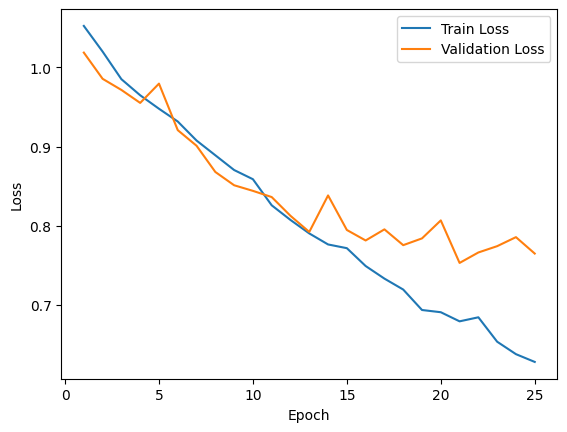

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# Extract only train and eval losses
train_logs = logs[logs['loss'].notna()]
eval_logs = logs[logs['eval_loss'].notna()]

plt.plot(train_logs['epoch'], train_logs['loss'], label='Train Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
#validation:
predictions = trainer.predict(test_dataset=tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.6753246753246753
F1: 0.6637034734327556
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       109
           1       0.47      0.35      0.40       101
           2       0.77      0.77      0.77       175

    accuracy                           0.68       385
   macro avg       0.64      0.65      0.64       385
weighted avg       0.66      0.68      0.66       385



In [21]:
#test:
predictions = trainer.predict(test_dataset=tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.7057142857142857
F1: 0.7022203703851345
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       102
           1       0.48      0.43      0.46        92
           2       0.83      0.82      0.82       156

    accuracy                           0.71       350
   macro avg       0.67      0.68      0.67       350
weighted avg       0.70      0.71      0.70       350



In [22]:
#trainer.save_model("/content/drive/MyDrive/age_classification/split1_model")
metrics_full = trainer.evaluate(tokenized_datasets['validation'])
print("Full validation metrics:", metrics_full)
metrics_full = trainer.evaluate(tokenized_datasets['test'])
print("Full test metrics:", metrics_full)


Full validation metrics: {'eval_loss': 0.7531834840774536, 'eval_accuracy': 0.6753246753246753, 'eval_f1': 0.6637034734327556, 'eval_runtime': 0.2547, 'eval_samples_per_second': 1511.839, 'eval_steps_per_second': 98.171, 'epoch': 25.0}
Full test metrics: {'eval_loss': 0.7293761372566223, 'eval_accuracy': 0.7057142857142857, 'eval_f1': 0.7022203703851345, 'eval_runtime': 0.1978, 'eval_samples_per_second': 1769.426, 'eval_steps_per_second': 111.221, 'epoch': 25.0}


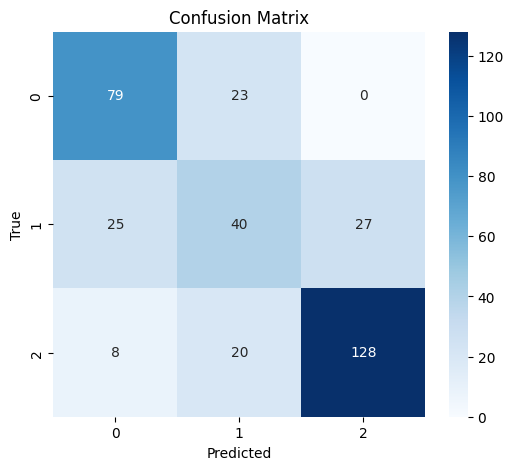

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#split 2

In [24]:
model_name = "prajjwal1/bert-tiny"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load model for classification with 3 labels
num_labels = 3

from transformers import AutoConfig, AutoModelForSequenceClassification

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.2,   # default is 0.1, increase to 0.2–0.5 for regularization
    attention_probs_dropout_prob=0.2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
data_path = "/content/drive/MyDrive/age classification/"

dataset = load_dataset('csv',
                       data_files={
                           'train': os.path.join(data_path, 'llmData_train_split2.csv'),
                           'validation': os.path.join(data_path, 'llmData_validation_split2.csv'),
                           'test': os.path.join(data_path, 'llmData_test_split2.csv')
                       })

# Map tokenization over dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)
label_map = {"2_3": 0, "3_4": 1, "4_6": 2}

def encode_labels(example):
    example["labels"] = label_map[example["class_range"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1094 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1094 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [26]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy with weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.483600,0.463255,0.501484,0.348282
2,0.475200,0.454957,0.498516,0.331686
3,0.470600,0.452593,0.498516,0.331686
4,0.464300,0.450737,0.498516,0.331686
5,0.467000,0.449936,0.498516,0.331686
6,0.465300,0.449086,0.498516,0.331686
7,0.466300,0.447391,0.498516,0.331686
8,0.465200,0.446736,0.498516,0.331686
9,0.463700,0.445985,0.498516,0.331686
10,0.460500,0.444635,0.498516,0.331686


TrainOutput(global_step=4968, training_loss=0.4535856312215808, metrics={'train_runtime': 60.254, 'train_samples_per_second': 1452.517, 'train_steps_per_second': 91.612, 'total_flos': 100104937979904.0, 'train_loss': 0.4535856312215808, 'epoch': 72.0})

In [27]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [ ]:


trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [28]:


# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure top layer is trainable
for param in model.classifier.parameters():
    param.requires_grad = True
trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.063000,1.049447,0.548961,0.479008
2,1.063300,1.050344,0.537092,0.531496
3,1.063700,1.051600,0.501484,0.507429
4,1.057200,1.051046,0.504451,0.515277
5,1.059400,1.051511,0.495549,0.508503


TrainOutput(global_step=345, training_loss=1.0613157410552536, metrics={'train_runtime': 4.3037, 'train_samples_per_second': 20336.191, 'train_steps_per_second': 1282.63, 'total_flos': 6951731804160.0, 'train_loss': 1.0613157410552536, 'epoch': 5.0})

In [29]:
#Unfreeze and train:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }


In [30]:

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


In [ ]:


trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [31]:


for param in model.bert.parameters():
    param.requires_grad = True

trainer.args.learning_rate = 2e-5 # use lower learning rate (e.g., 2e-5) for stability
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.048400,1.033594,0.468843,0.475899
2,1.027800,1.004826,0.501484,0.520200
3,1.008100,0.981922,0.504451,0.520971
4,0.981700,0.964233,0.501484,0.515020
5,0.962000,0.935586,0.540059,0.555182
6,0.928600,0.926788,0.557864,0.559850
7,0.911600,0.897840,0.596439,0.591630
8,0.881500,0.878904,0.623145,0.620801
9,0.860500,0.860614,0.664688,0.654811
10,0.834600,0.852568,0.640950,0.636788


TrainOutput(global_step=2070, training_loss=0.7538497206093608, metrics={'train_runtime': 59.392, 'train_samples_per_second': 1473.6, 'train_steps_per_second': 92.942, 'total_flos': 41710390824960.0, 'train_loss': 0.7538497206093608, 'epoch': 30.0})

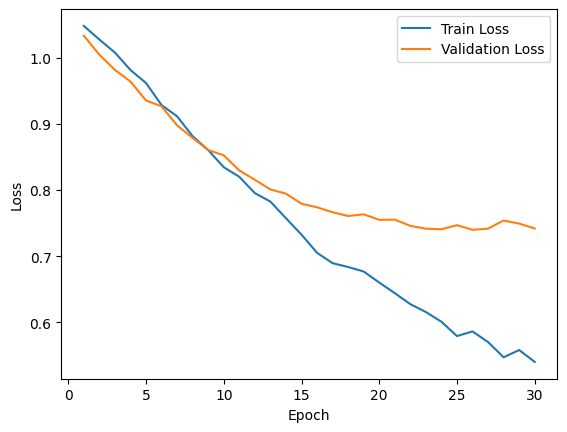

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# Extract only train and eval losses
train_logs = logs[logs['loss'].notna()]
eval_logs = logs[logs['eval_loss'].notna()]

plt.plot(train_logs['epoch'], train_logs['loss'], label='Train Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [33]:
#validation:
predictions = trainer.predict(test_dataset=tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.7091988130563798
F1: 0.7099724174478796
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        83
           1       0.50      0.52      0.51        86
           2       0.81      0.82      0.82       168

    accuracy                           0.71       337
   macro avg       0.68      0.67      0.68       337
weighted avg       0.71      0.71      0.71       337



In [34]:
#test:
predictions = trainer.predict(test_dataset=tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.69
F1: 0.68027318640955
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       123
           1       0.48      0.38      0.42       110
           2       0.73      0.84      0.78       167

    accuracy                           0.69       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.68      0.69      0.68       400



In [35]:
#trainer.save_model("/content/drive/MyDrive/age_classification/split2_model")
metrics_full = trainer.evaluate(tokenized_datasets['validation'])
print("Full validation metrics:", metrics_full)
metrics_full = trainer.evaluate(tokenized_datasets['test'])
print("Full test metrics:", metrics_full)

Full validation metrics: {'eval_loss': 0.7398959994316101, 'eval_accuracy': 0.7091988130563798, 'eval_f1': 0.7099724174478796, 'eval_runtime': 0.2237, 'eval_samples_per_second': 1506.396, 'eval_steps_per_second': 98.34, 'epoch': 30.0}
Full test metrics: {'eval_loss': 0.730797529220581, 'eval_accuracy': 0.69, 'eval_f1': 0.68027318640955, 'eval_runtime': 0.2395, 'eval_samples_per_second': 1670.129, 'eval_steps_per_second': 104.383, 'epoch': 30.0}


# Split3

In [50]:
model_name = "prajjwal1/bert-tiny"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load model for classification with 3 labels
num_labels = 3

from transformers import AutoConfig, AutoModelForSequenceClassification

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    hidden_dropout_prob=0.2,   # default is 0.1, increase to 0.2–0.5 for regularization
    attention_probs_dropout_prob=0.2
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

def tokenize_function(examples):
    return tokenizer(
        examples["child_text"],
        padding="max_length",  # pad to max_length
        truncation=True,       # truncate longer text
        max_length=512          # adjust if needed
    )

import os
from datasets import load_dataset
data_path = "/content/drive/MyDrive/age classification/"

dataset = load_dataset('csv',
                       data_files={
                           'train': os.path.join(data_path, 'llmData_train_split3.csv'),
                           'validation': os.path.join(data_path, 'llmData_validation_split3.csv'),
                           'test': os.path.join(data_path, 'llmData_test_split3.csv')
                       })
# Map tokenization over dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

label_map = {"2_3": 0, "3_4": 1, "4_6": 2}

def encode_labels(example):
    example["labels"] = label_map[example["class_range"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/353 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

In [51]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }

from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy with weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [52]:

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)




In [53]:
# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure top layer is trainable
for param in model.classifier.parameters():
    param.requires_grad = True
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.111400,1.111274,0.263708,0.136405
2,1.107600,1.104434,0.302872,0.239782
3,1.107800,1.099324,0.375979,0.371236
4,1.096000,1.098341,0.404700,0.380167
5,1.098800,1.097060,0.433420,0.385039
6,1.094100,1.096003,0.436031,0.364933
7,1.092300,1.093076,0.438642,0.386006
8,1.090600,1.092084,0.446475,0.393759
9,1.090500,1.090901,0.464752,0.405884
10,1.088500,1.089088,0.456919,0.418068


TrainOutput(global_step=5520, training_loss=1.07413698002912, metrics={'train_runtime': 68.2143, 'train_samples_per_second': 1284.188, 'train_steps_per_second': 80.921, 'total_flos': 111329379532800.0, 'train_loss': 1.07413698002912, 'epoch': 80.0})

In [54]:
#Unfreeze and train:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",  # log at the end of each epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    learning_rate=5e-5,
    load_best_model_at_end=True,
    report_to=[]  # disables W&B
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }


In [55]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


In [ ]:
trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


In [56]:

for param in model.bert.parameters():
    param.requires_grad = True

trainer.args.learning_rate = 2e-5 # use lower learning rate (e.g., 2e-5) for stability
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.055200,1.035130,0.501305,0.497647
2,1.029100,1.011168,0.488251,0.467561
3,1.011100,0.990574,0.571802,0.541762
4,0.976700,0.975861,0.537859,0.540177
5,0.955700,0.944944,0.569191,0.557727
6,0.922000,0.931289,0.569191,0.556972
7,0.899000,0.911856,0.566580,0.556969
8,0.879600,0.899230,0.579634,0.563844
9,0.843100,0.883576,0.582245,0.564267
10,0.823400,0.890411,0.584856,0.579424


TrainOutput(global_step=1242, training_loss=0.8524099955044315, metrics={'train_runtime': 35.1515, 'train_samples_per_second': 2492.072, 'train_steps_per_second': 157.035, 'total_flos': 25049110394880.0, 'train_loss': 0.8524099955044315, 'epoch': 18.0})

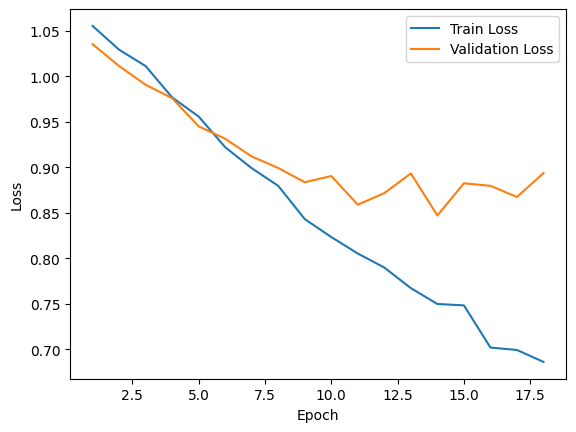

In [57]:
logs = pd.DataFrame(trainer.state.log_history)

# Extract only train and eval losses
train_logs = logs[logs['loss'].notna()]
eval_logs = logs[logs['eval_loss'].notna()]

plt.plot(train_logs['epoch'], train_logs['loss'], label='Train Loss')
plt.plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [58]:
#trainer.save_model("/content/drive/MyDrive/age_classification/split3_model")

metrics_full = trainer.evaluate(tokenized_datasets['test'])
print("Full model metrics:", metrics_full)


Full model metrics: {'eval_loss': 0.7871009707450867, 'eval_accuracy': 0.6827195467422096, 'eval_f1': 0.6658461176718172, 'eval_runtime': 0.2589, 'eval_samples_per_second': 1363.656, 'eval_steps_per_second': 88.85, 'epoch': 18.0}


In [59]:
#valid:
predictions = trainer.predict(test_dataset=tokenized_datasets['validation'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.6135770234986945
F1: 0.6053781228700401
              precision    recall  f1-score   support

           0       0.75      0.65      0.69       127
           1       0.36      0.30      0.33       102
           2       0.66      0.79      0.72       154

    accuracy                           0.61       383
   macro avg       0.59      0.58      0.58       383
weighted avg       0.61      0.61      0.61       383



In [60]:
#test:
predictions = trainer.predict(test_dataset=tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=1)  # convert logits to class labels
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds, average="weighted"))
print(classification_report(labels, preds))


Accuracy: 0.6827195467422096
F1: 0.6658461176718172
              precision    recall  f1-score   support

           0       0.74      0.79      0.76        81
           1       0.52      0.35      0.42       103
           2       0.72      0.83      0.77       169

    accuracy                           0.68       353
   macro avg       0.66      0.66      0.65       353
weighted avg       0.66      0.68      0.67       353



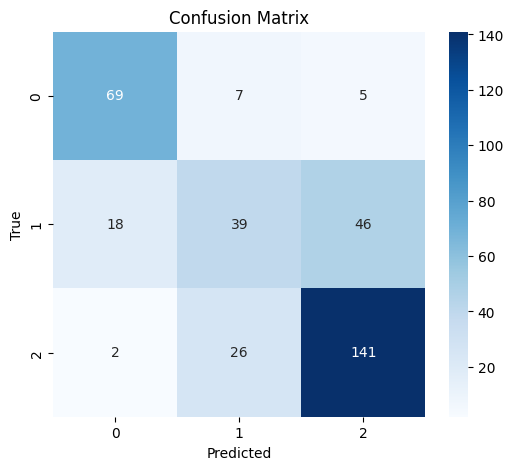

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#

AVEREGE:
| Metric   | Split 1 | Split 2 | Split 3 | **Mean**   |
| -------- | ------- | ------- | ------- | ---------- |
| Accuracy | 0.7057  | 0.6900  | 0.6827  | **0.6928** |
| F1 score | 0.7022  | 0.6803  | 0.6658  | **0.6828** |
